In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib.gridspec import GridSpec
import scanpy as sc
# import graphtools
import magic
from matplotlib.pyplot import rc_context
from matplotlib import gridspec
import os


from datashader.mpl_ext import dsshow
import datashader as ds

import matplotlib.colors
cmap = plt.cm.hsv
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[0:round(len(cmaplist)*0.7)]
cmaplist.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap.N)

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


import sys
sys.path.append('../../../Code/')
from utils import read_dataset_log, TCAT


In [3]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/Sparks


In [2]:
figdir = '../../../Figures/Components'
outdir = '../../../Data/PerDataset/Sparks2023/'

# Process counts matrix

In [ ]:
! ls ../../../Data/PerDataset/Sparks2023

GSE206265_covid_flu.CITEseq.pseudobulk.gene.expr.RDS  tmp_ADT_clr2.h5ad
GSE206265_covid_flu.CITEseq.Seurat.obj.RDS	      tmp_ADT_clr.h5ad
Manual_Gating_MagicProtein_20230513.tsv		      tmp_RNA_log2.h5ad
T_fromSeurat.h5ad				      tmp_RNA_log.h5ad
T_fromSeurat_metadata.txt


In [ ]:
os.path.abspath('../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad')

'/data/srlab1/TCAT/Data/PerDataset/Sparks2023/T_fromSeurat.h5ad'

In [2]:
adata = sc.read('../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 336739 × 28540
    obs: 'alt.subject.id', 'visit', 'covid.diagnosis.start.date.to.sample.drawn', 'group', 'sex', 'age', 'race', 'ethnicity', 'flu.vax.count.10yr', 'vaccine', 'vaccine.side.effects', 'long.covid.symptoms', 'Batch', 'nCount_RNA', 'nCount_HTO', 'nCount_CITE', 'nCount_RNA_largest.gene', 'nCount_SCT', 'nFeature_RNA', 'nFeature_HTO', 'nFeature_CITE', 'nFeature_SCT', 'percent.mt', 'percent.largest.gene', 'coarse.cell.type', 'cell.type', 'HTO1', 'HTO2', 'HTO3'
    var: 'gene_ids', 'feature_types'

In [14]:
harmony_vars = ['alt.subject.id']

## MAGIC Markers

In [15]:
adata.X.sum(axis=1)

matrix([[ 3791.],
        [ 6830.],
        [11117.],
        ...,
        [ 8544.],
        [ 4524.],
        [ 5437.]], dtype=float32)

In [16]:
ind = adata.var['feature_types']=='Antibody Capture'

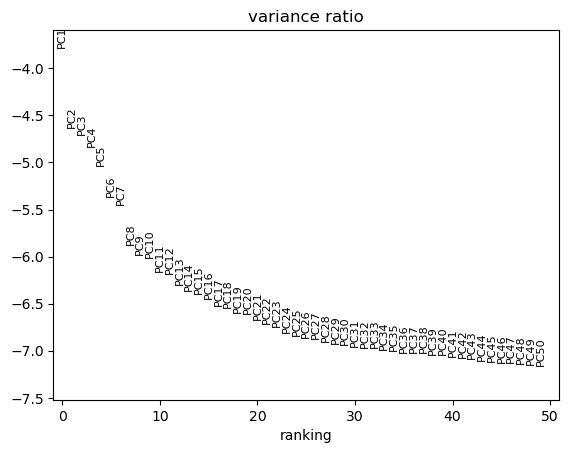

In [17]:
adata_RNA = adata[:,~ind].copy()
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=2000)
sc.pp.normalize_per_cell(adata_RNA, counts_per_cell_after=1e4)
sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA, zero_center=False)
sc.tl.pca(adata_RNA, use_highly_variable=True, zero_center=True)
sc.pl.pca_variance_ratio(adata_RNA, log=True, n_pcs=50)

In [19]:
sc.external.pp.harmony_integrate(adata_RNA,  harmony_vars, max_iter_harmony = 30)


2023-09-12 22:54:25,849 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-09-12 22:55:57,490 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-09-12 22:56:00,786 - harmonypy - INFO - Iteration 1 of 30
2023-09-12 22:59:42,824 - harmonypy - INFO - Iteration 2 of 30
2023-09-12 23:03:48,326 - harmonypy - INFO - Iteration 3 of 30
2023-09-12 23:08:14,447 - harmonypy - INFO - Iteration 4 of 30
2023-09-12 23:12:17,074 - harmonypy - INFO - Iteration 5 of 30
2023-09-12 23:19:06,084 - harmonypy - INFO - Iteration 6 of 30
2023-09-12 23:23:44,242 - harmonypy - INFO - Converged after 6 iterations


In [21]:
sc.pp.neighbors(adata_RNA, n_neighbors=5, n_pcs=31, use_rep='X_pca_harmony')

/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
outfn = os.path.join(outdir, 'RNA_logTP1K_ForMAGIC.h5ad')
print(outfn)

../../../Data/PerDataset/Sparks2023/RNA_logTP1K_ForMAGIC.h5ad


In [4]:
# adata_RNA.write(outfn)

In [ ]:
adata_RNA = sc.read(outfn)

Neighbors function kills kernel. Return to whatever this environment issue is later if necessary.

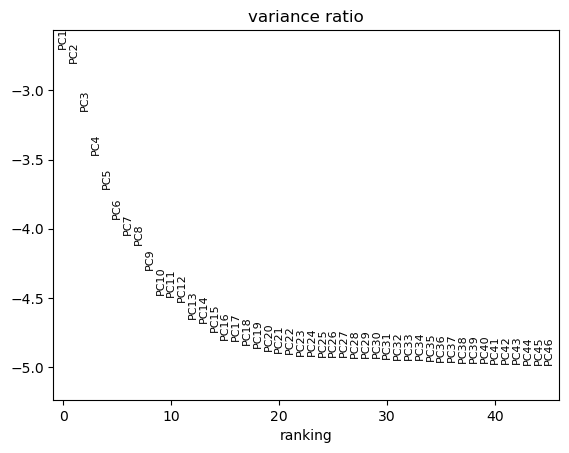

In [24]:
adata_ADT = adata[:,ind].copy()
sc.pp.normalize_per_cell(adata_ADT, counts_per_cell_after=1e4)
Z = adata_ADT.X.todense()
Z[Z==0] = np.nan
gmean = np.exp(np.nansum(np.log(Z+1), axis=1) / Z.shape[1])
Z = np.log((Z / gmean) + 1)
Z[np.isnan(Z)]=0
adata_ADT.X = np.array(Z)

sc.pp.scale(adata_ADT, zero_center=False, max_value=15)

sc.tl.pca(adata_ADT, zero_center=True)
sc.pl.pca_variance_ratio(adata_ADT, log=True, n_pcs=45)

In [25]:
sc.external.pp.harmony_integrate(adata_ADT,  harmony_vars, max_iter_harmony = 30)

2023-09-13 00:06:55,126 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-09-13 00:09:51,226 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-09-13 00:09:56,618 - harmonypy - INFO - Iteration 1 of 30
2023-09-13 00:17:32,085 - harmonypy - INFO - Iteration 2 of 30
2023-09-13 00:24:55,685 - harmonypy - INFO - Converged after 2 iterations


In [26]:
sc.pp.neighbors(adata_ADT, n_neighbors=5, n_pcs=23, use_rep='X_pca_harmony')

In [ ]:
outfn = os.path.join(outdir, 'ADT_TP10KCLR_ForMAGIC.h5ad')
print(outfn)

In [28]:
# adata_ADT.write(outfn)

In [ ]:
adata_ADT = sc.read(outfn)

In [58]:
['TRAC', 'TRGC1', 'TRDC', 'TRBC1']
rna_markers = [ 'IL2RA', 'FOXP3', 'SELL', 'CCR7', 'KLRB1', 'RTKN2', 'IL7R', 'PASK', 'GATA3',
               'CCR4', 'STAT1', 'IRF4', 'TBX21', 'IFNG', 'CCR5', 'CXCR3', 'CCR6', 'CCL20', 'IL4R', 'IL4', 'STAT4',  'STAT6',  'CCR1', 'IL10',
               'IL17B', 'IL17A', 'IL17F', 'IL17D', 'IL17C', 'RORC', 'RORA', 'STAT3']

In [59]:
set(rna_markers) - set(adata_RNA.var.index)

set()

In [60]:
adt_markers = ['AB_CD3', 'AB_CD4',
               'AB_CD8', 'AB_CD45RA', 'AB_CD45RO',  'AB_CD18', 'AB_CD161',  'AB_CD194', 'AB_CD195', 'AB_CD196', 'AB_CD183',
               'AB_CD25', 'AB_CD127', 
               'AB_CD27',

               
                'AB_TCRValpha7p2', 'AB_TCRVdelta2', 'AB_TCRab',
               
               
               'AB_CD31', 'AB_CD62L', 
               'AB_CD314',
               'AB_CD38', 'AB_CD39',
              'AB_CD94', 'AB_CD49b', 'AB_CD28'] 

In [61]:
set(adt_markers) - set(adata_ADT.var.index)

set()

In [62]:
adt_markers = list(set(adt_markers).intersection(adata_ADT.var.index))

In [63]:
G = graphtools.Graph(data=adata_RNA.obsp['connectivities'], precomputed='affinity')
magic_operator = magic.MAGIC(t=3)
magic_operator.fit(adata_RNA.X, graph=G)
markers_magic = magic_operator.transform(X=adata_RNA[:, rna_markers].X)
markers_magic = pd.DataFrame(markers_magic, index=adata_RNA.obs.index, columns=rna_markers)

Running MAGIC on 336739 cells and 28402 genes.


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


Using precomputed graph and diffusion operator...


/PHShome/dk718/.local/lib/python3.7/site-packages/magic/magic.py:426: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  "Input matrix contains unexpressed genes. "


Calculating imputation...


/PHShome/dk718/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 0.61 seconds.


In [64]:
G = graphtools.Graph(data=adata_ADT.obsp['connectivities'], precomputed='affinity')
magic_operator = magic.MAGIC(t=3)
magic_operator.fit(adata_ADT.X, graph=G)
markers_magic_adt = magic_operator.transform(X=adata_ADT[:, adt_markers].X)
markers_magic_adt = pd.DataFrame(markers_magic_adt, index=adata_ADT.obs.index, columns=adt_markers)

Running MAGIC on 336739 cells and 138 genes.
Using precomputed graph and diffusion operator...


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


Calculating imputation...


/PHShome/dk718/.local/lib/python3.7/site-packages/magic/magic.py:546: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  UserWarning,


Calculated imputation in 0.45 seconds.


In [65]:
for g in adt_markers:
    markers_magic[g] = markers_magic_adt[g]
    
# markers_magic['frac_ADT'] = adata.obs['frac_ADT']

In [4]:
outfn = os.path.join(outdir, 'ManualGating.MagicMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv')
print(outfn)

../../../Data/PerDataset/Sparks2023/ManualGating.MagicMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv


In [67]:
# markers_magic.to_csv(outfn, sep='\t')

In [5]:
markers_magic = pd.read_csv(outfn, sep='\t', index_col=0)

In [6]:
markers_magic.head()

,IL2RA,FOXP3,SELL,CCR7,KLRB1,RTKN2,IL7R,PASK,GATA3,CCR4,...,AB_CD127,AB_CD314,AB_TCRab,AB_CD183,AB_CD196,AB_CD161,AB_CD49b,AB_CD8,AB_CD194,AB_TCRValpha7p2
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,0.034438,0.000000,1.517741,1.423799,0.026807,0.023047,2.075596,0.291445,0.408416,0.000000,...,2.682153,1.862191,2.762960,4.088069,0.752272,1.242627,1.014027,0.101815,1.065427,0.485914
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,0.418152,0.000000,1.379186,1.108463,0.200547,0.875604,2.652840,0.253289,0.641875,0.326209,...,2.577376,1.432514,1.895910,3.840267,0.825811,1.321210,1.063946,0.156864,1.522671,0.444084
Batch1_COVFLU_CITE_multi5P02_GATGCTACAGCTTAAC-1,0.094362,0.000000,1.784834,1.575621,0.070373,0.058975,2.430046,0.395325,0.579676,0.014996,...,2.719017,1.625544,2.812393,3.726086,0.804815,1.037392,1.000376,0.193916,1.144573,0.432645
Batch1_COVFLU_CITE_multi5P03_AGGGTGACATTAGGCT-1,0.056848,0.000000,0.504855,0.016812,0.308043,0.074840,0.369897,0.003142,0.492720,0.000000,...,1.822498,3.117837,2.173253,4.583472,0.768745,1.418158,1.373131,1.409964,1.021188,0.551723
Batch1_COVFLU_CITE_multi5P10_GAACCTACAACGCACC-1,0.000000,0.028196,1.040649,0.538739,0.077138,0.095968,1.174182,0.350994,0.659467,0.172477,...,3.454602,1.503789,2.216669,3.727961,0.530886,1.196640,0.966706,0.211634,2.909371,0.489792


In [7]:
markers_magic.columns

Index(['IL2RA', 'FOXP3', 'SELL', 'CCR7', 'KLRB1', 'RTKN2', 'IL7R', 'PASK',
       'GATA3', 'CCR4', 'STAT1', 'IRF4', 'TBX21', 'IFNG', 'CCR5', 'CXCR3',
       'CCR6', 'CCL20', 'IL4R', 'IL4', 'STAT4', 'STAT6', 'CCR1', 'IL10',
       'IL17B', 'IL17A', 'IL17F', 'IL17D', 'IL17C', 'RORC', 'RORA', 'STAT3',
       'AB_CD195', 'AB_CD27', 'AB_CD28', 'AB_CD4', 'AB_CD38', 'AB_CD62L',
       'AB_CD18', 'AB_CD94', 'AB_TCRVdelta2', 'AB_CD31', 'AB_CD3', 'AB_CD39',
       'AB_CD45RO', 'AB_CD25', 'AB_CD45RA', 'AB_CD127', 'AB_CD314', 'AB_TCRab',
       'AB_CD183', 'AB_CD196', 'AB_CD161', 'AB_CD49b', 'AB_CD8', 'AB_CD194',
       'AB_TCRValpha7p2'],
      dtype='object')

In [70]:
unsmoothed_markers = pd.DataFrame(np.concatenate([adata_RNA[:, rna_markers].X.toarray(), np.array(adata_ADT[:, adt_markers].X)], axis=1), index=adata_RNA.obs.index,
             columns=(rna_markers+adt_markers))

In [8]:
outfn = os.path.join(outdir, 'ManualGating.UnsmoothedMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv')
print(outfn)

../../../Data/PerDataset/Sparks2023/ManualGating.UnsmoothedMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv


In [72]:
# unsmoothed_markers.to_csv(outfn, sep='\t')

In [9]:
unsmoothed_markers = pd.read_csv(outfn, sep='\t', index_col=0)

In [10]:
markers = list(markers_magic.columns)

## Protein-RNA correlations

In [74]:
from scipy.stats import pearsonr

In [75]:
prot_pairs = [#('CCR7', 'AB_CD197_CCR7'),
             ('SELL', 'AB_CD62L'),
             ('IL2RA', 'AB_CD25'),
             ('FOXP3', 'AB_CD25'),
             # ('TRDC', 'AB_gdTCR'),
             # ('TRDC', 'AB_abTCR')
]

In [76]:
'AB_CD25' in markers_magic.columns

True

In [77]:
'IL2RA' in markers_magic.columns

True

In [78]:
'FOXP3' in markers_magic.columns

True

In [79]:
markers_magic.columns

Index(['IL2RA', 'FOXP3', 'SELL', 'CCR7', 'KLRB1', 'RTKN2', 'IL7R', 'PASK',
       'GATA3', 'CCR4', 'STAT1', 'IRF4', 'TBX21', 'IFNG', 'CCR5', 'CXCR3',
       'CCR6', 'CCL20', 'IL4R', 'IL4', 'STAT4', 'STAT6', 'CCR1', 'IL10',
       'IL17B', 'IL17A', 'IL17F', 'IL17D', 'IL17C', 'RORC', 'RORA', 'STAT3',
       'AB_CD195', 'AB_CD27', 'AB_CD28', 'AB_CD4', 'AB_CD38', 'AB_CD62L',
       'AB_CD18', 'AB_CD94', 'AB_TCRVdelta2', 'AB_CD31', 'AB_CD3', 'AB_CD39',
       'AB_CD45RO', 'AB_CD25', 'AB_CD45RA', 'AB_CD127', 'AB_CD314', 'AB_TCRab',
       'AB_CD183', 'AB_CD196', 'AB_CD161', 'AB_CD49b', 'AB_CD8', 'AB_CD194',
       'AB_TCRValpha7p2'],
      dtype='object')

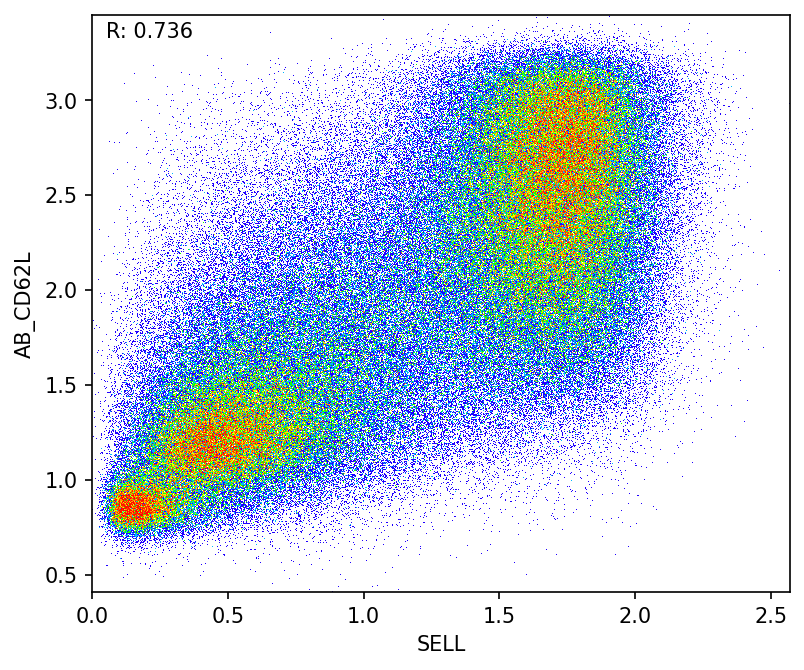

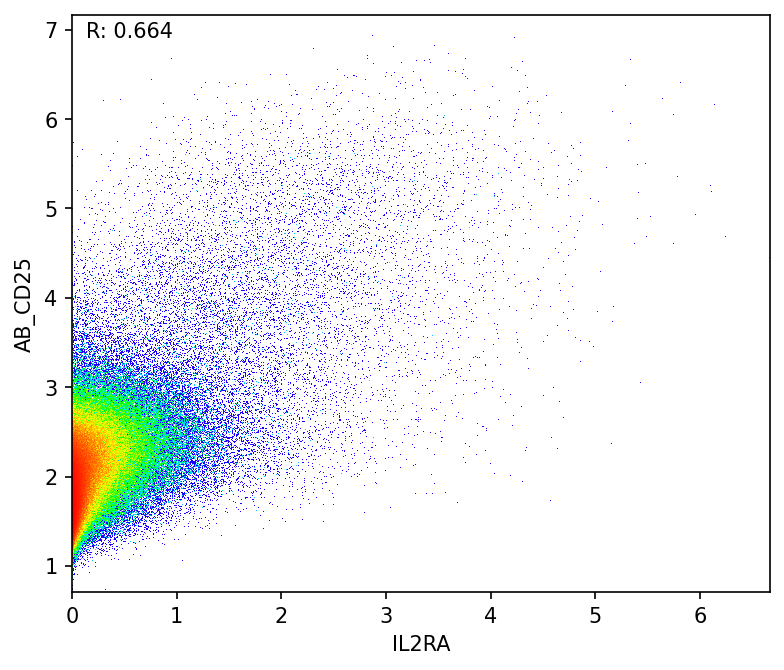

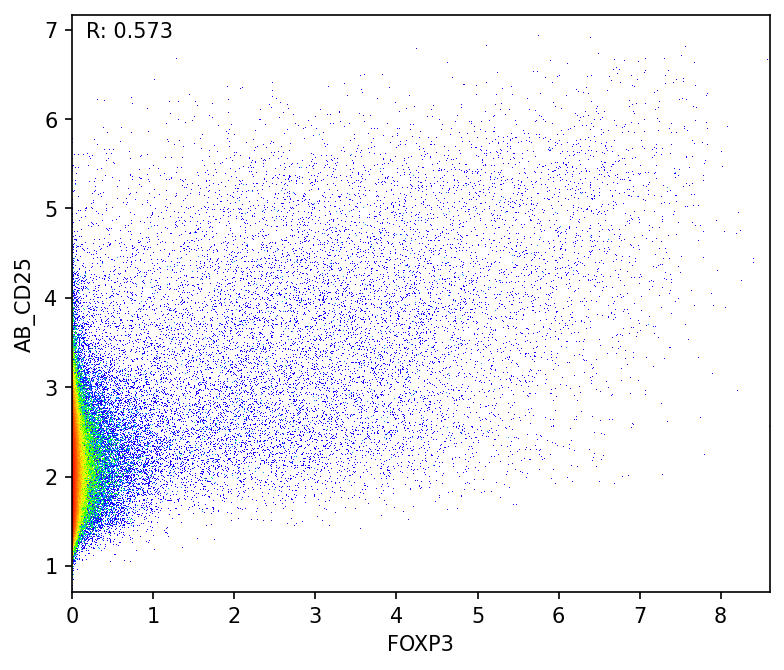

In [80]:
for (gene, prot) in prot_pairs:
    # print(gene, prot)
    r, _ = pearsonr(markers_magic[gene], markers_magic[prot])
    # print(r)
    
    fig, ax = plt.subplots(dpi = 150, figsize=(6,5))
    dsshow(pd.DataFrame({'x':markers_magic[gene], 'y':markers_magic[prot]}), 
           ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = ax, aspect = 'auto')
    # ax.scatter(x = markers_magic[gene], y = markers_magic[prot], s = .2, alpha = .3)
    ax.text(.02, .96, ''.join(['R: ', str(round(r, 3))]), transform=ax.transAxes)
    ax.set_xlabel(gene)
    ax.set_ylabel(prot)

## Compare non MAGIC-smoothed markers

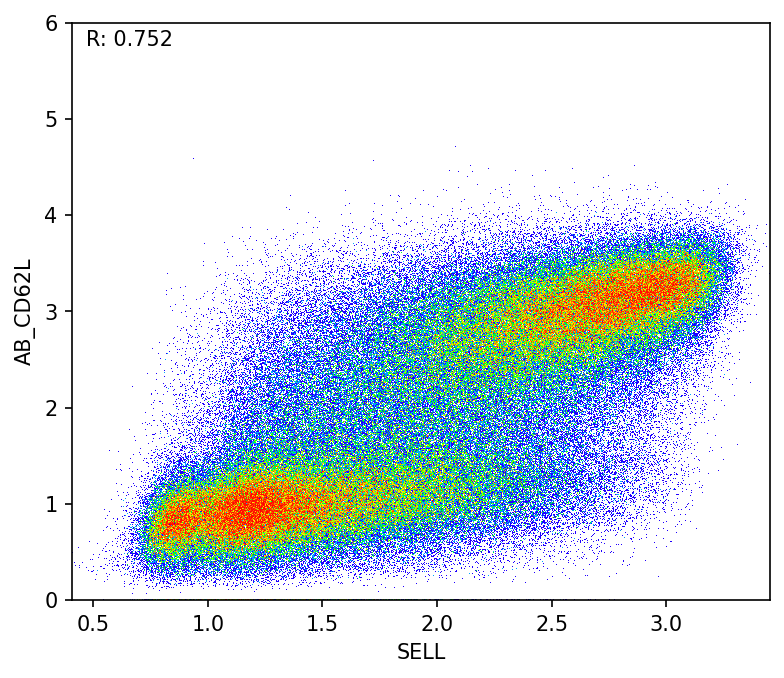

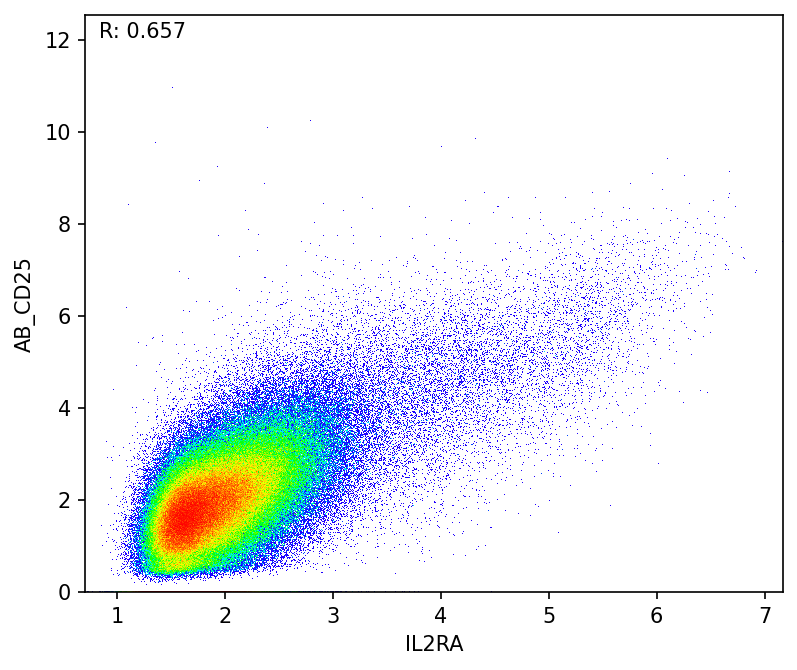

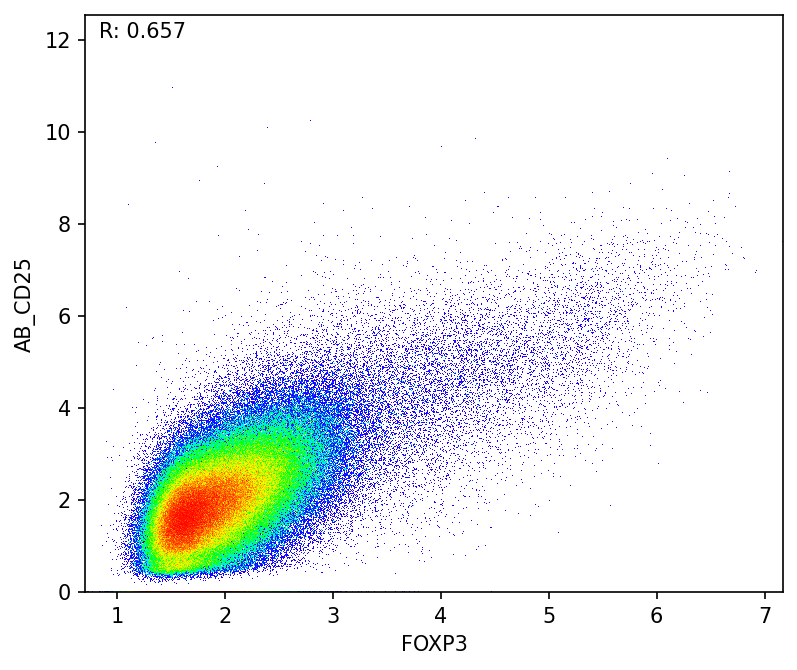

In [86]:
for (gene, prot) in prot_pairs:
    # print(gene, prot)
    r, _ = pearsonr(markers_magic[prot], unsmoothed_markers[prot])
    # print(r)
    
    fig, ax = plt.subplots(dpi = 150, figsize=(6,5))
    dsshow(pd.DataFrame({'x':markers_magic[prot], 'y':unsmoothed_markers[prot]}), 
           ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = ax, aspect = 'auto')
    # ax.scatter(x = markers_magic[gene], y = markers_magic[prot], s = .2, alpha = .3)
    ax.text(.02, .96, ''.join(['R: ', str(round(r, 3))]), transform=ax.transAxes)
    ax.set_xlabel(gene)
    ax.set_ylabel(prot)

## Lineage marker gating

In [11]:
cmap = plt.cm.hsv
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[0:round(len(cmaplist)*0.7)]
cmaplist.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap.N)
    
def gate(data, g1, g2, ind=None, vertical_gate=None, horizontal_gate=None, quadrant_gate=None,
         labfontsize=9, plot_labeled=False, upper_only=False , logx=False, logy=False, offset=.1):
    
    
    
    fig = plt.figure(constrained_layout=True, figsize=(2., 2.), dpi=200)
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.95, top=.92)
    ax = fig.add_subplot(gs[0])

    if ind  is None:
        ind = pd.Series(np.array([True]*data.shape[0]), data.index)
    
    
    x = data.loc[ind, g1]
    y = data.loc[ind, g2]
    
    if logx: x = np.log(x + offset)
    if logy: y = np.log(y + offset)
    
    dsshow(pd.DataFrame({'x':x, 'y':y}), ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = ax, aspect = 'auto')
    
    if logx:
        ax.set_xlabel('log2 ' + g1, fontsize=labfontsize)
    else:
        ax.set_xlabel(g1, fontsize=labfontsize)
        
    if logy:
        ax.set_ylabel('log2 ' + g2, fontsize=labfontsize)        
    else:
        ax.set_ylabel(g2, fontsize=labfontsize)

    
    if vertical_gate is not None:
        xlim = ax.get_xlim()
        ax.hlines(y=vertical_gate['vthresh'], xmin=xlim[0], xmax=xlim[1], linestyle='--', color='k', linewidth=1)
        ax.set_xlim(xlim)
        
            
        initial_res = (data.loc[ind, g2]>vertical_gate['vthresh']).replace({True:vertical_gate['above_name'], False:vertical_gate['below_name']})
        final_res = ind.copy()
        final_res.loc[ind] = initial_res
        final_res.loc[~ind] = np.nan
    elif horizontal_gate is not None:
        ylim = ax.get_ylim()
        ax.vlines(x=horizontal_gate['hthresh'], ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', linewidth=1)
        ax.set_ylim(ylim)
        
        initial_res = (data.loc[ind, g1]>horizontal_gate['hthresh']).replace({False:horizontal_gate['left_name'], True:horizontal_gate['right_name']})
        final_res = ind.copy()
        final_res.loc[ind] = initial_res
        final_res.loc[~ind] = np.nan
        
        
    elif quadrant_gate is not None:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        if not upper_only:
            ax.hlines(y=quadrant_gate['vthresh'], xmin=xlim[0]-1, xmax=xlim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_xlim(xlim)
            ax.vlines(x=quadrant_gate['hthresh'], ymin=ylim[0]-1, ymax=ylim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_ylim(ylim)
        else:
            ax.hlines(y=quadrant_gate['vthresh'], xmin=quadrant_gate['hthresh'], xmax=xlim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_xlim(xlim)
            ax.vlines(x=quadrant_gate['hthresh'], ymin=quadrant_gate['vthresh'], ymax=ylim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_ylim(ylim)            
            

        indh = data.loc[ind, g1]> quadrant_gate['hthresh']
        indv = data.loc[ind, g2]> quadrant_gate['vthresh']
        final_res = ind.replace(False,np.nan)
        for hval,vval, lab in [[False, False, quadrant_gate['ll']], [True, False, quadrant_gate['lr']], [False, True, quadrant_gate['ul']], [True, True, quadrant_gate['ur']]]:
            tolab = (indh==hval) & (indv==vval)
            final_res.loc[tolab.index[tolab]] = lab
            
            
    if plot_labeled:
        fig = plt.figure(constrained_layout=True, figsize=(2.4, 2.), dpi=200)
        gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.8, top=.92)
        ax2 = fig.add_subplot(gs[0])
        dat = pd.concat([x,y,final_res], axis=1)
        dat.columns = [g1, g2, 'label']
        for (k,g) in dat.groupby('label'):
            ax2.scatter(g[g1], g[g2], label=k, s=.5, edgecolor='None')
        ax2.legend(bbox_to_anchor=(1,1), markerscale=3, fontsize=6)
        
        
        
    return(final_res, ax)

In [97]:
gating = pd.DataFrame(index=markers_magic.index, 
                      columns=['gdT', 'MAIT', 'CD4_vs_CD8', 'Treg', 'CD4_Conv', 'CD8_Conv'])

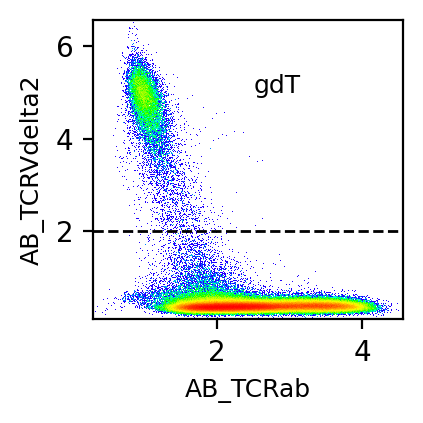

In [98]:
g1 = 'AB_TCRab'
g2 = 'AB_TCRVdelta2'   
vgate = {'vthresh':2, 'above_name':'gdT', 'below_name':'ab'}
gating['gdT'], ax = gate(markers_magic, g1, g2, ind=None, vertical_gate=vgate, plot_labeled=False)
ax.text(2.5,5, 'gdT', fontsize=9)
plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_gdT.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_gdT.pdf'))

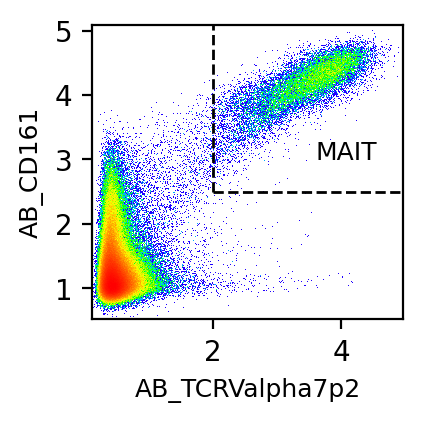

In [99]:
g1 = 'AB_TCRValpha7p2'
g2 = 'AB_CD161'  
gating['MAIT'], ax = gate(markers_magic, g1, g2, ind=gating['gdT']=='ab',
                      quadrant_gate={'vthresh':2.5, 'hthresh':2, 'ur':'MAIT', 'ul':'ab', 'll':'ab', 'lr':'ab'}, plot_labeled=False, upper_only=True)
ax.text(3.6,3, 'MAIT', fontsize=9)
plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_MAIT.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_MAIT.pdf'))

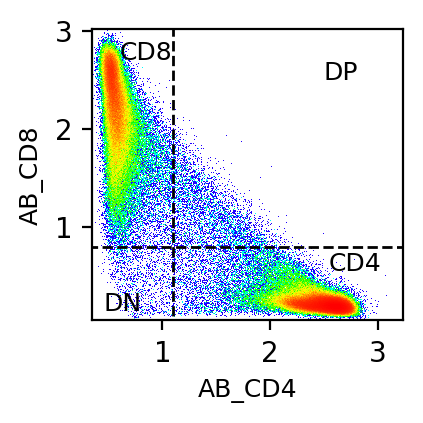

In [100]:
g1 = 'AB_CD4'
g2 = 'AB_CD8'    
gating['CD4_vs_CD8'], ax = gate(markers_magic, g1, g2, ind=gating['MAIT']=='ab', quadrant_gate={'vthresh':.8, 'hthresh':1.1, 'll':'DN', 'ul':'CD8', 'ur':'DP', 'lr':'CD4'},
                            plot_labeled=False)
ax.text(.6,2.7, 'CD8', fontsize=9)
ax.text(2.55, .55, 'CD4', fontsize=9)
ax.text(2.5,2.5, 'DP', fontsize=9)
ax.text(.45, .15, 'DN', fontsize=9)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0], xlim[1]+.15)

plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_CD4CD8.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_CD4CD8.pdf'))

Text(6.5, 1, 'Treg')

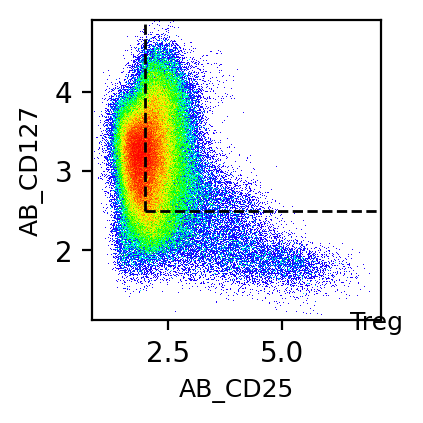

In [42]:
g2 = 'AB_CD127'     
g1 = 'AB_CD25'

_,ax = gate(markers_magic, g1, g2, ind=gating['CD4_vs_CD8']=='CD4', 
            quadrant_gate={'vthresh':2.5, 'hthresh':2, 'ur':'CD4', 'ul':'CD4', 'll':'CD4', 'lr':'Treg'}, 
            plot_labeled=False, upper_only=True
            
            # horizontal_gate={'hthresh':1.5, 'right_name':'Treg', 'left_name':'CD4'},
            #           plot_labeled=False
           )

ax.text(6.5, 1, 'Treg', fontsize=9)
# ax.set_xlabel('FOXP3 RNA', fontsize=9)

# plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_Treg.png'))
# plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_Treg.pdf'))

Text(0.5, 0, 'FOXP3 RNA')

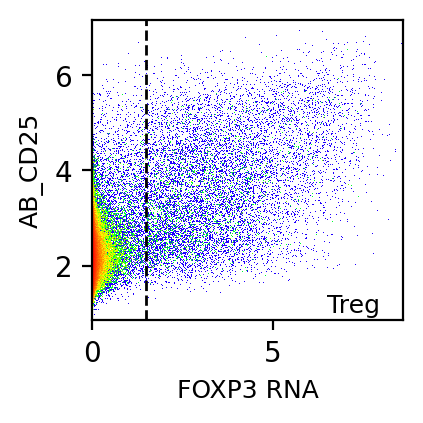

In [49]:
g2 = 'AB_CD25'     
g1 = 'FOXP3'

_,ax = gate(markers_magic, g1, g2, ind=gating['CD4_vs_CD8']=='CD4', horizontal_gate={'hthresh':1.5, 'right_name':'Treg', 'left_name':'CD4'},
                      plot_labeled=False)

ax.text(6.5, 1, 'Treg', fontsize=9)
ax.set_xlabel('FOXP3 RNA', fontsize=9)

# plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_Treg.png'))
# plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_Treg.pdf'))

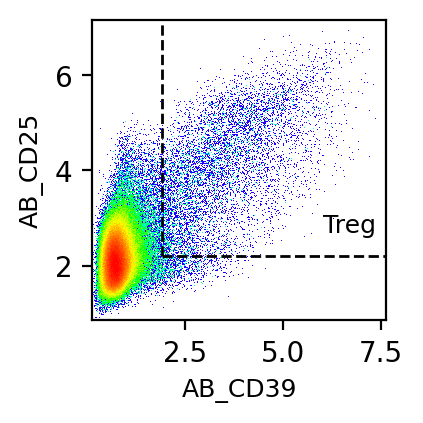

In [105]:
g2 = 'AB_CD25'     
g1 = 'AB_CD39'

gating['Treg'],ax = gate(markers_magic, g1, g2, ind=gating['CD4_vs_CD8']=='CD4', 
               quadrant_gate={'vthresh':2.2, 'hthresh':1.9, 
                              'll':'CD4', 'ur':'Treg', 'ul':'CD4', 'lr':'CD4'
                             },
                      plot_labeled=False, upper_only=True)

ax.text(6, 2.7, 'Treg', fontsize=9)

plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_Treg.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_Treg.pdf'))

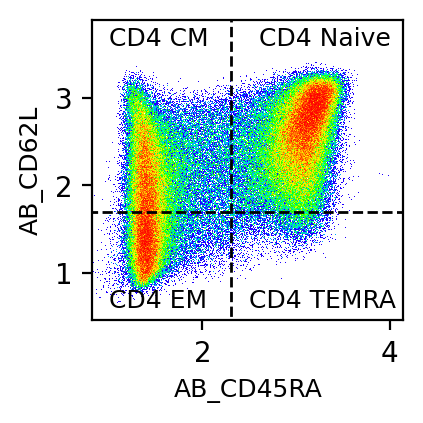

In [106]:
g1 = 'AB_CD45RA'     
g2 = 'AB_CD62L'
gating['CD4_Conv'],ax = gate(markers_magic, g1, g2, ind=(gating['Treg']=='CD4'),
                           quadrant_gate={'vthresh':1.7, 'hthresh':2.3, 'll':'CD4_EM', 'ur':'CD4_Naive', 'ul':'CD4_CM', 'lr':'CD4_TEMRA'},
                           plot_labeled=False)

ax.text(2.6, 3.6, 'CD4 Naive', fontsize=9)
ax.text(2.5, .6, 'CD4 TEMRA', fontsize=9)

ax.text(1., 3.6, 'CD4 CM', fontsize=9)
ax.text(1., .6, 'CD4 EM', fontsize=9)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0], xlim[1]+.15)
ax.set_ylim(ylim[0]-.2, ylim[1]+.5)


plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_CD4Naive.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_CD4Naive.pdf'))

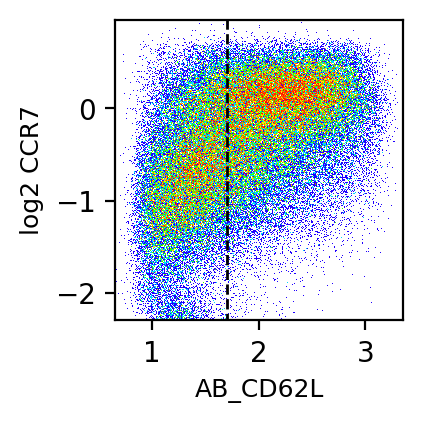

In [107]:
g1 = 'AB_CD62L'     
g2 = 'CCR7'
_ = gate(markers_magic, g1, g2, ind=(gating['CD4_Conv'].isin(['CD4_CM', 'CD4_EM'])),
         quadrant_gate={'vthresh':1.7, 'hthresh':1.7, 'll':'CD4_Memory', 'ul':'CD4_Naive', 'ur':'CD4_Memory', 'lr':'CD4_Memory'},
        logy=True, logx=False)


Text(0.5, 0, 'SELL RNA')

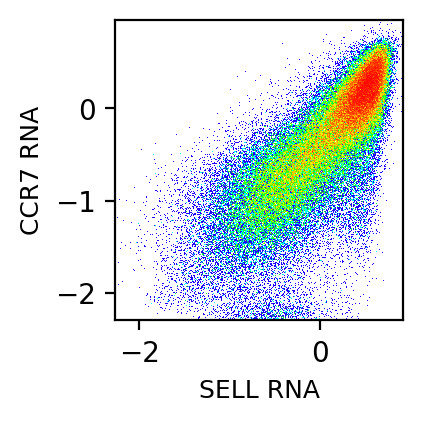

In [108]:
g1 = 'SELL'     
g2 = 'CCR7'
_,ax = gate(markers_magic, g1, g2,
            ind=(gating['CD4_Conv'].isin(['CD4_CM', 'CD4_EM'])),
            quadrant_gate={'vthresh':1.7, 'hthresh':1.7, 'll':'CD4_Memory', 'ul':'CD4_Naive', 'ur':'CD4_Memory', 'lr':'CD4_Memory'},
           logx=True, logy=True)
ax.set_ylabel('CCR7 RNA', fontsize=9)
ax.set_xlabel('SELL RNA', fontsize=9)

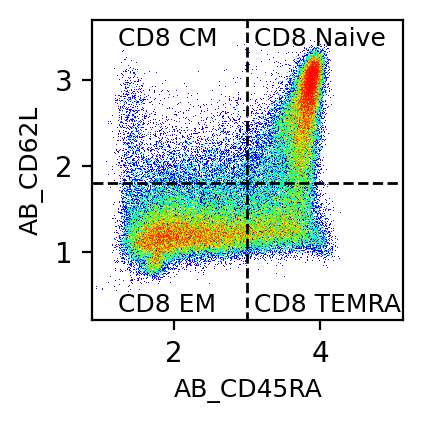

In [109]:
g1 = 'AB_CD45RA'     
g2 = 'AB_CD62L'
gating['CD8_Conv'], ax = gate(markers_magic, g1, g2, ind=(gating['CD4_vs_CD8']=='CD8'),
                           quadrant_gate={'vthresh':1.8, 'hthresh':3, 'll':'CD8_EM', 'ul':'CD8_CM', 'ur':'CD8_Naive', 'lr':'CD8_TEMRA'},
                                                             plot_labeled=False)

ax.text(3.1, 3.4, 'CD8 Naive', fontsize=9)
ax.text(3.1, .3, 'CD8 TEMRA', fontsize=9)

ax.text(1.24, 3.4, 'CD8 CM', fontsize=9)
ax.text(1.24, .3, 'CD8 EM', fontsize=9)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0], xlim[1]+.85)
ax.set_ylim(ylim[0]-.3, ylim[1]+.25)


plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_CD8Naive.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_SPARKS_CD8Naive.pdf'))

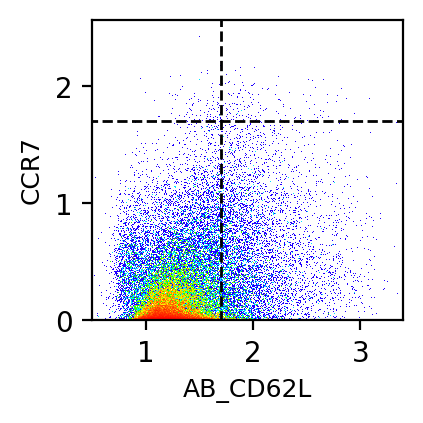

In [110]:
g1 = 'AB_CD62L'     
g2 = 'CCR7'
_ = gate(markers_magic, g1, g2, ind=(gating['CD8_Conv'].isin(['CD8_CM', 'CD8_EM'])),
         quadrant_gate={'vthresh':1.7, 'hthresh':1.7, 'll':'CD4_Memory', 'ul':'CD4_Naive', 'ur':'CD4_Memory', 'lr':'CD4_Memory'},
        logy=False, logx=False)


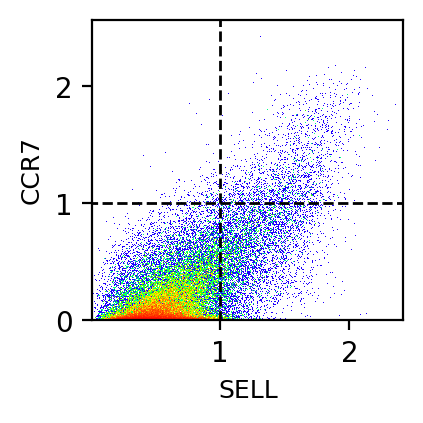

In [111]:
g1 = 'SELL'     
g2 = 'CCR7'
_ = gate(markers_magic, g1, g2, ind=(gating['CD8_Conv'].isin(['CD8_CM', 'CD8_EM'])),
         quadrant_gate={'vthresh':1., 'hthresh':1., 'll':'CD4_Memory', 'ul':'CD4_Naive', 'ur':'CD4_Memory', 'lr':'CD4_Memory'},
        logy=False, logx=False)

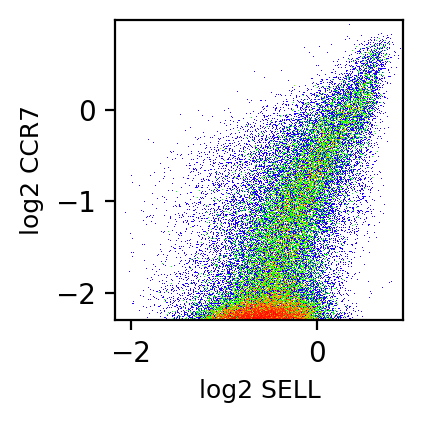

In [112]:
g1 = 'SELL'     
g2 = 'CCR7'
_ = gate(markers_magic, g1, g2, ind=(gating['CD8_Conv'].isin(['CD8_CM', 'CD8_EM'])),
         quadrant_gate={'vthresh':1., 'hthresh':1., 'll':'CD4_Memory', 'ul':'CD4_Naive', 'ur':'CD4_Memory', 'lr':'CD4_Memory'},
        logy=True, logx=True)

In [113]:
label = gating.apply(lambda x: x[x.last_valid_index()], axis=1)

In [114]:
outfn = os.path.join(outdir, 'ManualGating.Magic.20231116.tsv')
print(outfn)

../../../Data/PerDataset/Sparks2023/ManualGating.Magic.20231116.tsv


In [115]:
gating.to_csv(outfn, sep='\t')

In [116]:
label.value_counts()

CD4_Naive    96784
CD4_CM       56439
CD4_EM       40883
CD8_EM       39647
CD8_Naive    29266
MAIT         18065
CD8_TEMRA    16914
gdT          14822
Treg          8146
CD8_CM        5187
CD4_TEMRA     4735
DP            4408
DN            1443
dtype: int64

In [117]:
outfn = os.path.join(outdir, 'ManualGating.Magic.FinalLabel.20231116.tsv')
print(outfn)

../../../Data/PerDataset/Sparks2023/ManualGating.Magic.FinalLabel.20231116.tsv


In [118]:
label.to_csv(outfn, sep='\t')

In [119]:
os.path.abspath(outfn)

'/data/srlab1/TCAT/Data/PerDataset/Sparks2023/ManualGating.Magic.FinalLabel.20231116.tsv'

## Run TCAT and overlap with GEPs

In [138]:
metagep_params = read_dataset_log('Current Meta-program Paths').iloc[0,:]
metagep_params

clustering_fn                      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                        /data/srlab1/TCAT/Data/TCAT/MergedHVG.UnionAll...
tpm_norm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_norm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                     /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
Name: 0, dtype: object

In [139]:
ref_fn = metagep_params['tpm_norm_spectra']
hvg_fn = metagep_params['merged_hvgs']

ref = pd.read_csv(ref_fn, sep='\t', index_col=0)
hvgs = pd.read_csv(hvg_fn, sep='\t', header=None)[0]
ref = ref[hvgs]
ref.iloc[:5,:5]

,A1BG,AARD,AARSD1,ABCA1,ABCB1
CellCycle-G2M_CellCycle_G2M,1.692606,26.154948,16.493128,3.123680,2.204518
ISG,3.364326,0.000000,17.544046,16.271238,0.000000
gdT,0.714961,0.000000,16.937122,2.053485,120.099903
Metallothionein,39.064559,3.819360,14.068480,0.000000,0.000000
CellCycle-Sphase_CellCycle_S_DTL/FAM111B,2.571766,11.238854,28.163834,1.332667,0.386387


In [141]:
adata = sc.read('../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad')

In [143]:
adata = adata[:,adata.var['feature_types']=='Gene Expression']

In [144]:
tmod = TCAT(alpha=0, l1_ratio=0, tpm_norm=False, var_norm=True, copy=True)
rf_usage = tmod.fit_transform(adata, ref_spectra=ref)

3393 out of 3393 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [146]:
tcat_gep_info = read_dataset_log('GEP_Name')
tcat_gep_info.head()

,MetaGep_Name,Long_Name,Short_Name,Needs Review,Class,Num_Datasets,Flag
0,CellCycle-G2M_CellCycle_G2M,Cell Cycle G2M Phase,CellCycle-G2M,NaN,Known Activity,7.0,NaN
1,ISG,Interferon Stimulated Genes,ISG,NaN,Known Activity,7.0,NaN
2,gdT,Gamma Delta T Blood,gdT-Blood,NaN,Known Lineage,4.0,NaN
3,Metallothionein,Metallothionein,Metallothionein,NaN,Known Activity,5.0,NaN
4,CellCycle-Sphase_CellCycle_S_DTL/FAM111B,Cell Cycle S Phase,CellCycle-S,NaN,Known Activity,7.0,NaN


In [147]:
rename_map = dict(zip(tcat_gep_info['MetaGep_Name'], tcat_gep_info['Short_Name']))

In [149]:
rf_usage_ren = rf_usage.rename(rename_map, axis=1)

In [154]:
rf_usage_ren_norm = rf_usage_ren.div(rf_usage_ren.sum(axis=1), axis=0)

# Overlap with Lineage

In [155]:
cluster = rf_usage_ren_norm.groupby(label).mean()

In [156]:
cluster.idxmax(axis=1)

CD4_CM          MALAT1
CD4_EM          MALAT1
CD4_Naive    CD4-Naive
CD4_TEMRA    CD4-Naive
CD8_CM          MALAT1
CD8_EM          CD8_EM
CD8_Naive    CD8-Naive
CD8_TEMRA    Cytotoxic
DN           NK-Like-2
DP              MALAT1
MAIT              MAIT
Treg              Treg
gdT          gdT-Blood
dtype: object

In [157]:
cmax = cluster.max(axis=0).sort_values(ascending=False)
toconsider = cmax.index[cmax>0.02]
toconsider

Index(['MAIT', 'Treg', 'CD8-Naive', 'CD4-Naive', 'gdT-Blood', 'Cytotoxic',
       'CD8_EM', 'MALAT1', 'NK-Like-2', 'gdT', 'BCL2/CDK6', 'Translation',
       'Mito', 'Th17', 'CD4 TEM', 'ICOS/CCR4', 'Doublet-Plasma', 'IL10/CD38',
       'KLRC2/GNLY', 'S100A10/LMNA', 'Doublet-Plasma-2', 'Doublet-Myeloid',
       'CD4 TCM', 'Th2', 'HeatShock2', 'CH25H/DDIT4', 'IEG', 'NK-Like-3',
       'Cytoskeleton', 'YPEL5/CREM', 'IEG-Tissue', 'CD244/CD8', 'HLA', 'Tfh',
       'RGCC/MYADM', 'CD8/KLRC2', 'TNFRSF18+-Treg', 'SOX4/MME'],
      dtype='object')

In [158]:
ratio = {}
for c in toconsider:
    sortedv = cluster[c].sort_values(ascending=False)
    ratio[c] = sortedv.iloc[0]/sortedv.iloc[1]

In [159]:
pd.Series(ratio).sort_values(ascending=False).index

Index(['Treg', 'MAIT', 'NK-Like-3', 'CD8-Naive', 'IL10/CD38', 'gdT-Blood',
       'Doublet-Plasma-2', 'TNFRSF18+-Treg', 'Doublet-Myeloid', 'Th17',
       'ICOS/CCR4', 'CD8_EM', 'CD4 TCM', 'CD4 TEM', 'KLRC2/GNLY', 'NK-Like-2',
       'CH25H/DDIT4', 'gdT', 'Cytotoxic', 'HLA', 'MALAT1', 'IEG', 'Mito',
       'CD4-Naive', 'CD244/CD8', 'HeatShock2', 'YPEL5/CREM', 'S100A10/LMNA',
       'Translation', 'Doublet-Plasma', 'RGCC/MYADM', 'CD8/KLRC2', 'BCL2/CDK6',
       'Tfh', 'IEG-Tissue', 'SOX4/MME', 'Th2', 'Cytoskeleton'],
      dtype='object')

In [160]:
sorted(set(cluster.columns) - set(toconsider))

['CCR3+-Th2',
 'CTLA4+CD38+',
 'CTSH/Furin',
 'CellCycle-G2M',
 'CellCycle-Histone',
 'CellCycle-S',
 'Doublet-Bcell',
 'Doublet-Platelet',
 'Doublet-RBC',
 'EBI3-Activation',
 'Exhaustion',
 'FCN3/FCN2',
 'HeatShock1',
 'High-Cytokine',
 'ICOS/ACTG1',
 'IEG-Blood',
 'IL26/CTSH',
 'ISG',
 'METRNL/CREM',
 'Metallothionein',
 'TIMD4/CD38',
 'Tph']

In [163]:
cluster = rf_usage_ren_norm.groupby(label).mean()
cluster

,CellCycle-G2M,ISG,gdT-Blood,Metallothionein,CellCycle-S,Doublet-RBC,CellCycle-Histone,HeatShock1,Mito,S100A10/LMNA,...,CTSH/Furin,TNFRSF18+-Treg,ICOS/CCR4,KLRC2/GNLY,NK-Like-2,Doublet-Plasma-2,METRNL/CREM,CD244/CD8,CH25H/DDIT4,NK-Like-3
CD4_CM,0.002487,0.017734,0.003785,0.003929,0.006832,0.001220,0.002907,0.014434,0.024823,0.037084,...,0.009695,0.010640,0.048118,0.002727,0.004042,0.009699,0.005062,0.012404,0.031233,0.002028
CD4_EM,0.001988,0.017284,0.007226,0.003835,0.005876,0.001238,0.002489,0.014004,0.034499,0.041280,...,0.010864,0.011201,0.024438,0.005120,0.006938,0.008429,0.006725,0.013636,0.023101,0.002804
CD4_Naive,0.001640,0.015486,0.003218,0.003835,0.006907,0.001213,0.002368,0.014790,0.033576,0.004202,...,0.006503,0.008620,0.031347,0.001472,0.002841,0.009743,0.005127,0.012088,0.022701,0.002690
CD4_TEMRA,0.001497,0.015650,0.004889,0.003892,0.006725,0.001089,0.002229,0.012401,0.055605,0.004737,...,0.007294,0.007864,0.025460,0.003085,0.009211,0.009477,0.005005,0.011458,0.018328,0.004204
CD8_CM,0.002088,0.015093,0.012871,0.005188,0.006270,0.001033,0.002458,0.014143,0.027606,0.030486,...,0.005542,0.007733,0.022434,0.015159,0.009285,0.041105,0.007857,0.020017,0.018328,0.003551
CD8_EM,0.002187,0.012699,0.020756,0.006417,0.006256,0.001493,0.002465,0.012680,0.027050,0.015681,...,0.004916,0.007894,0.008280,0.019161,0.041448,0.015446,0.010877,0.025461,0.009745,0.003550
CD8_Naive,0.001512,0.012914,0.004625,0.004656,0.006516,0.001204,0.002055,0.015069,0.044958,0.003192,...,0.004969,0.006412,0.012880,0.003555,0.004234,0.016356,0.005997,0.020111,0.014148,0.002899
CD8_TEMRA,0.001842,0.010018,0.026453,0.005826,0.005873,0.001309,0.001947,0.011204,0.026455,0.008156,...,0.003963,0.006818,0.005039,0.043788,0.099580,0.013258,0.009767,0.022120,0.005644,0.005891
DN,0.004086,0.011443,0.038697,0.006085,0.005747,0.001837,0.002843,0.010155,0.036137,0.011083,...,0.004280,0.006837,0.007112,0.028983,0.071845,0.016639,0.007107,0.012082,0.007756,0.027742
DP,0.002476,0.014681,0.011242,0.005321,0.007281,0.001820,0.002982,0.012949,0.036052,0.033368,...,0.007024,0.008861,0.021477,0.010208,0.020535,0.013056,0.006991,0.017444,0.015808,0.003279


Text(0.5, 1.0, 'Example Other')

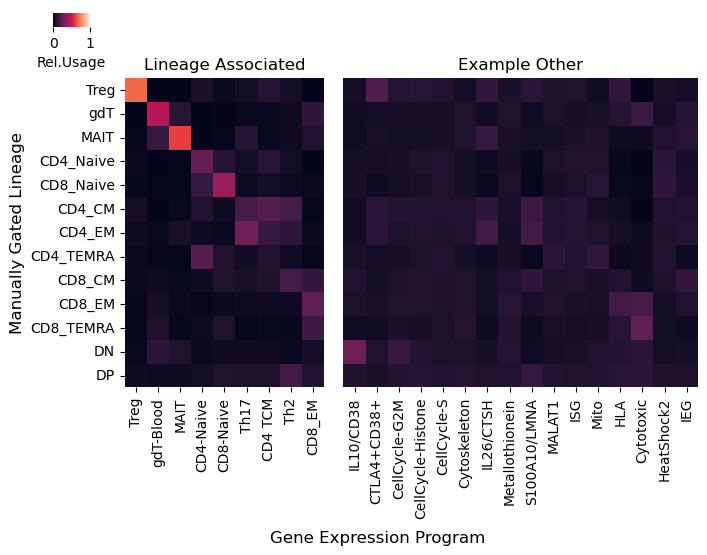

In [162]:
cluster = rf_usage_ren_norm.groupby(label).mean()

lineage_order = ['Treg', 'gdT', 'MAIT','CD4_Naive',  'CD8_Naive', 'CD4_CM', 'CD4_EM', 'CD4_TEMRA',  'CD8_CM', 'CD8_EM',  'CD8_TEMRA',
                 'DN', 'DP',  ]


max_usage = cluster.max(axis=0).sort_values(ascending=False)


lineage_geps = ['Treg', 'gdT-Blood', 'MAIT', 'CD4-Naive', 'CD8-Naive', 'Th17',  'CD4 TCM', 'Th2','CD8_EM']
other_geps = [ 'IL10/CD38', 'CTLA4+CD38+',
 'CellCycle-G2M',
 'CellCycle-Histone',
 'CellCycle-S',
 'Cytoskeleton',
 'IL26/CTSH',
 'Metallothionein',
'S100A10/LMNA', 'MALAT1',  'ISG', 'Mito', 'HLA',  'Cytotoxic',  'HeatShock2', 'IEG']
gep_order = lineage_geps + other_geps

cluster = cluster.loc[lineage_order, gep_order]


cluster_norm = cluster.div(cluster.sum(axis=0), axis=1)



frac_lineage = (len(lineage_geps) / len(lineage_geps+other_geps))
frac_other = 1-frac_lineage



fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3, width_ratios=[0.05, frac_lineage, frac_other], height_ratios=[.1,.9], wspace=0.1, bottom=0.25)

# Colorbar axis
top_ax = fig.add_subplot(gs[0, 0:2])
lin_ax = fig.add_subplot(gs[1,1])
other_ax = fig.add_subplot(gs[1, 2])
top_ax.axis('off')


cax = top_ax.inset_axes([-0.1, .5, 0.15, 0.4], transform=top_ax.transAxes)
#fig.colorbar(scim, ax=axes[x,y], cax=cax, orientation='horizontal')



sns.heatmap(cluster_norm.loc[:,lineage_geps], ax=lin_ax, cbar_ax=cax, xticklabels=True, cbar_kws={'label': 'Rel.Usage', 'orientation':'horizontal',
                                                                               'ticks':[0,1], 'shrink':0.1, 'aspect':30}, vmin=0, vmax=1)
sns.heatmap(cluster_norm.loc[:,other_geps], ax=other_ax, cbar=False, vmin=0, vmax=1, xticklabels=True)
other_ax.set_yticks([])
lin_ax.set_ylabel('Manually Gated Lineage', fontsize=12)
other_ax.set_ylabel('')
fig.text(0.5, 0, 'Gene Expression Program', ha='center', va='center', fontsize=12)

lin_ax.set_title('Lineage Associated', fontsize=12)
other_ax.set_title('Example Other', fontsize=12)

#plt.savefig(os.path.join(figdir, 'LineageAssociate_COMBAT_Relative.png'))
#plt.savefig(os.path.join(figdir, 'LineageAssociate_COMBAT_Relative.pdf'))

Text(0.5, 1.0, 'Example Other')

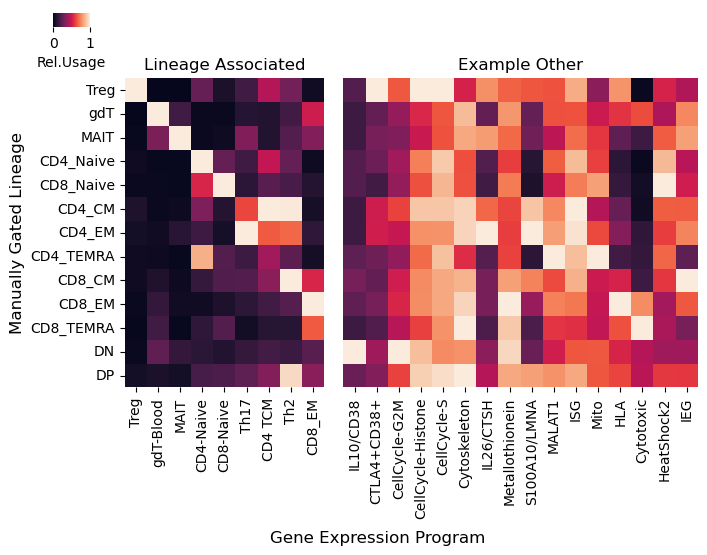

In [165]:
cluster = rf_usage_ren_norm.groupby(label).mean()

lineage_order = ['Treg', 'gdT', 'MAIT','CD4_Naive',  'CD8_Naive', 'CD4_CM', 'CD4_EM', 'CD4_TEMRA',  'CD8_CM', 'CD8_EM',  'CD8_TEMRA',
                 'DN', 'DP',  ]


max_usage = cluster.max(axis=0).sort_values(ascending=False)


lineage_geps = ['Treg', 'gdT-Blood', 'MAIT', 'CD4-Naive', 'CD8-Naive', 'Th17',  'CD4 TCM', 'Th2','CD8_EM']
other_geps = [ 'IL10/CD38', 'CTLA4+CD38+',
 'CellCycle-G2M',
 'CellCycle-Histone',
 'CellCycle-S',
 'Cytoskeleton',
 'IL26/CTSH',
 'Metallothionein',
'S100A10/LMNA', 'MALAT1',  'ISG', 'Mito', 'HLA',  'Cytotoxic',  'HeatShock2', 'IEG']
gep_order = lineage_geps + other_geps

cluster = cluster.loc[lineage_order, gep_order]


cluster_norm = cluster.div(cluster.max(axis=0), axis=1)



frac_lineage = (len(lineage_geps) / len(lineage_geps+other_geps))
frac_other = 1-frac_lineage



fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 3, width_ratios=[0.05, frac_lineage, frac_other], height_ratios=[.1,.9], wspace=0.1, bottom=0.25)

# Colorbar axis
top_ax = fig.add_subplot(gs[0, 0:2])
lin_ax = fig.add_subplot(gs[1,1])
other_ax = fig.add_subplot(gs[1, 2])
top_ax.axis('off')


cax = top_ax.inset_axes([-0.1, .5, 0.15, 0.4], transform=top_ax.transAxes)
#fig.colorbar(scim, ax=axes[x,y], cax=cax, orientation='horizontal')



sns.heatmap(cluster_norm.loc[:,lineage_geps], ax=lin_ax, cbar_ax=cax, xticklabels=True, cbar_kws={'label': 'Rel.Usage', 'orientation':'horizontal',
                                                                               'ticks':[0,1], 'shrink':0.1, 'aspect':30}, vmin=0, vmax=1)
sns.heatmap(cluster_norm.loc[:,other_geps], ax=other_ax, cbar=False, vmin=0, vmax=1, xticklabels=True)
other_ax.set_yticks([])
lin_ax.set_ylabel('Manually Gated Lineage', fontsize=12)
other_ax.set_ylabel('')
fig.text(0.5, 0, 'Gene Expression Program', ha='center', va='center', fontsize=12)

lin_ax.set_title('Lineage Associated', fontsize=12)
other_ax.set_title('Example Other', fontsize=12)

#plt.savefig(os.path.join(figdir, 'LineageAssociate_COMBAT_Relative.png'))
#plt.savefig(os.path.join(figdir, 'LineageAssociate_COMBAT_Relative.pdf'))